In [11]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
from adjoint_esn.utils.dynamical_systems import Lorenz63, Lorenz96
import adjoint_esn.utils.solve_ode as solve_ode
from adjoint_esn.utils import preprocessing as pp
from adjoint_esn.esn import ESN
from adjoint_esn.validation import set_ESN
from adjoint_esn.utils import errors,scalers

## Generate data

In [162]:
sys = Lorenz63

# simulation options
sim_time = 500
transient_time = 20
sim_dt = 2e-2
network_dt = 2e-2

# noise
noise_level = 0.0
noise_std = np.sqrt(5.0)

# training options
washout_time = 1
train_time = 120
val_time = 20
test_time = 20

# parameters
beta = 8/3
sigma = 10
rho = 28
params = {"beta":beta, "rho":rho, "sigma":sigma}
input_vars = ["x","y","z"]
param_vars = ["beta","rho","sigma"]

my_sys, y_sim, t_sim = pp.load_data_dyn_sys(sys,params,sim_time,sim_dt,random_seed=0)

DATA = pp.create_dataset_dyn_sys(my_sys,y_sim,t_sim,params,
                    network_dt=network_dt,
                    transient_time=transient_time,
                    washout_time=washout_time,
                    input_vars=input_vars,
                    param_vars=param_vars,
                    loop_times=[train_time,val_time,test_time],
                    loop_names=["train","val","test"],
                    noise_level=noise_level,
                    noise_std=noise_std)

DATA_clean = pp.create_dataset_dyn_sys(my_sys,y_sim,t_sim,params,
                    network_dt=network_dt,
                    transient_time=transient_time,
                    washout_time=washout_time,
                    input_vars=input_vars,
                    param_vars=param_vars,
                    loop_times=[train_time,val_time,test_time],
                    loop_names=["train","val","test"],
                    noise_level=0.0,
                    noise_std=0.0)

## Hyperparameter search

In [13]:
# from adjoint_esn.validation import validate as validate_v2

# # hyperparameter names, should match the attributes of ESN
# hyp_param_names = ['input_scaling','spectral_radius']

# # range for hyperparameters 
# spec_in     = 0.01
# spec_end    = 1.0
# in_scal_in  = 0.1
# in_scal_end = 10.0
# leak_in     = 0.1    
# leak_end    = 1.0
# tikh_in = 1e-8
# tikh_end = 1e-1
# grid_range = [[in_scal_in, in_scal_end],
#               [spec_in, spec_end]]

# # scales, uniform or log10
# hyp_param_scales = ['log10','log10']

# # scale the ranges
# for i in range(len(grid_range)):
#     for j in range(2):
#         scaler = getattr(scalers, hyp_param_scales[i])
#         grid_range[i][j] = scaler(grid_range[i][j])
        
# N_washout = int(np.round(washout_time/network_dt))
# fold_time = 1
# N_val = int(np.round(fold_time/network_dt))
# N_transient = 0
# ESN_dict = {'reservoir_size': 500, 
#             'dimension' : 3, 
#             'parameter_dimension' : 0,
#             'reservoir_connectivity' : 5,
#             'input_weights_mode': "sparse_grouped",
#             'reservoir_weights_mode': "erdos_renyi1",
#             'input_only_mode': False,
#             'tikhonov': 1e-6,
#             'leak_factor': 0.3
#             }
# min_dict = validate_v2(grid_range,hyp_param_names,hyp_param_scales,
#     n_calls = 50, n_initial_points = 10,
#     ESN_dict = ESN_dict, ESN_type = "standard",
#     U_washout_train = DATA["train"]["u_washout"],
#     U_train = DATA["train"]["u"],
#     U_val = DATA["val"]["u"],
#     Y_train = DATA["train"]["y"],
#     Y_val = DATA["val"]["y"],
#     n_folds=5,
#     n_realisations=3,
#     N_washout_steps = N_washout,
#     N_val_steps = N_val,
#     N_transient_steps = N_transient,
#     n_grid = None,
#     error_measure=errors.rel_L2)

In [176]:
# either set from the hyperparameter search 
# my_ESN = ESN(**ESN_dict,verbose=False)
# hyp_params = [min_dict[hyp_param_name][0] for hyp_param_name in hyp_param_names]
# hyp_param_scales = ['uniform']*len(hyp_param_names)
# set_ESN(my_ESN,hyp_param_names,hyp_param_scales,hyp_params)
            
# or use pre-selected values
ESN_dict = {'reservoir_size': 500, 
            'dimension' : 3, 
            'parameter_dimension' : 0,
            'reservoir_connectivity' : 5,
            'input_weights_mode': "sparse_grouped",
            'reservoir_weights_mode': "erdos_renyi1",
            'input_only_mode': False,
            'tikhonov': 1e-3,
            'leak_factor': 0.3,
            'input_scaling': 0.14,
            'spectral_radius': 0.57
            }     
my_ESN = ESN(**ESN_dict,verbose=False)
my_ESN.train(DATA["train"]["u_washout"], 
             DATA["train"]["u"], 
             DATA["train"]["y"])
Wo_ls = my_ESN.W_out

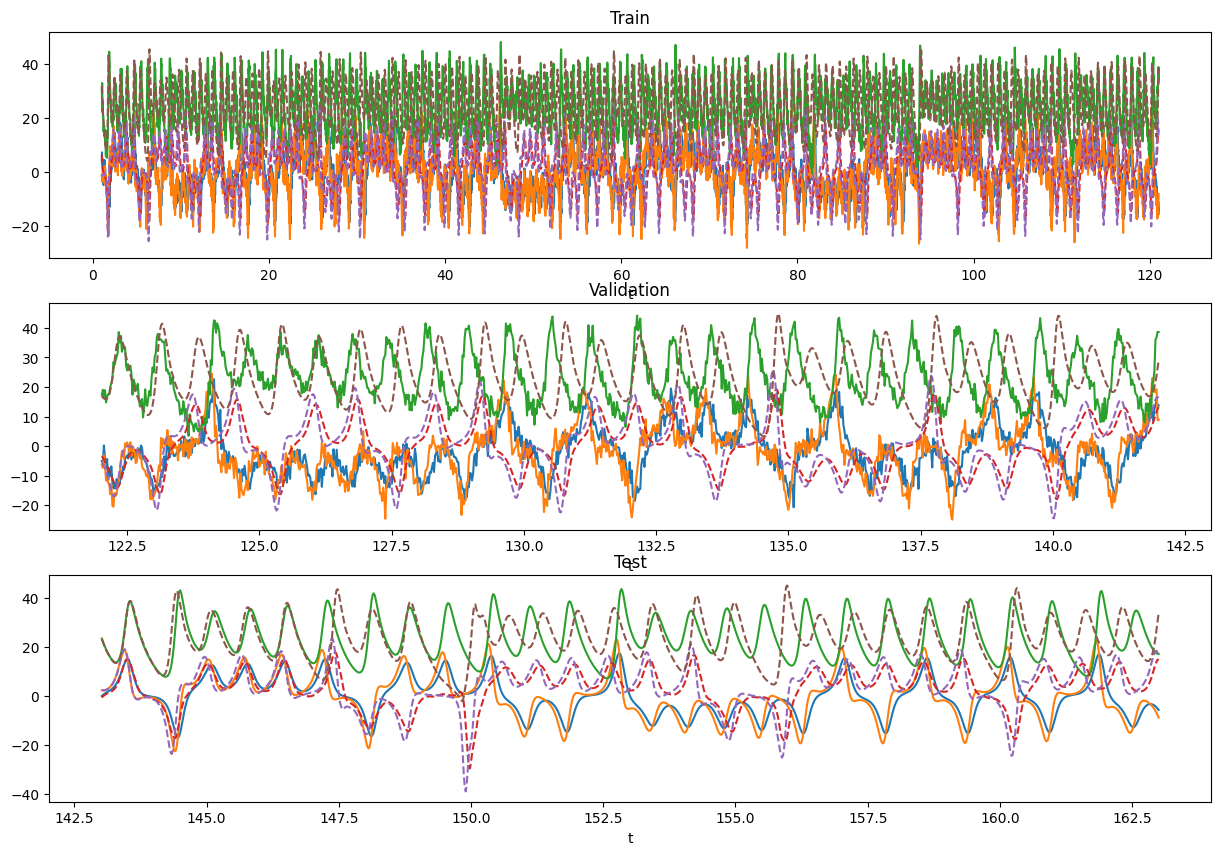

In [177]:
my_ESN.W_out = Wo_ls
_, y_pred = my_ESN.closed_loop_with_washout(U_washout=DATA["train"]["u_washout"], 
                                                    N_t=len(DATA["train"]["u"]))
y_pred = y_pred[1:]
plt.figure(figsize=(15,10))
plt.subplot(3,1,1)
plt.plot(DATA["train"]["t"],DATA["train"]["y"])
plt.plot(DATA["train"]["t"],y_pred,'--')
plt.xlabel('t')
plt.title('Train')

_, y_pred = my_ESN.closed_loop_with_washout(U_washout=DATA["val"]["u_washout"], 
                                                    N_t=len(DATA["val"]["u"]))
y_pred = y_pred[1:]
plt.subplot(3,1,2)
plt.plot(DATA["val"]["t"],DATA["val"]["y"])
plt.plot(DATA["val"]["t"],y_pred,'--')
plt.xlabel('t')
plt.title('Validation')

_, y_pred = my_ESN.closed_loop_with_washout(U_washout=DATA_clean["test"]["u_washout"], 
                                                    N_t=len(DATA_clean["test"]["u"]))
y_pred = y_pred[1:]
plt.subplot(3,1,3)
plt.plot(DATA_clean["test"]["t"],DATA_clean["test"]["y"])
plt.plot(DATA_clean["test"]["t"],y_pred,'--')
plt.xlabel('t')
plt.title('Test')

plt.show()

## Train with EnKF

In [172]:
# noise std
# sigma_v = np.diag(noise_level/100*np.std(DATA_clean["train"]["u"],axis=0))
sigma_v = noise_std**2 * np.eye(3)

# initialize data ensemble
M = 300
std_u = np.sqrt(0.2)
u0 = DATA["train"]["u"][0][:,None]
u_est = np.repeat(u0, M, axis = 1)
u_est = u_est + std_u * np.random.randn(u_est.shape[0],M)

# initialize reservoir 
# x = np.zeros((my_ESN.N_reservoir, M)) # no washout?
x0 = my_ESN.run_washout(DATA["train"]["u_washout"])[:,None]
x = np.repeat(x0, M, axis = 1)

# initialize Wout
std_w = np.sqrt(0.2)
Wo_est0 = np.reshape(Wo_ls,my_ESN.W_out.shape[0]*my_ESN.W_out.shape[1])[:,None]
Wo_est = std_w * np.random.randn(my_ESN.W_out.shape[0]*my_ESN.W_out.shape[1], M)

N = len(DATA["train"]["u"]) # timesteps

u_est_arr = np.zeros((u_est.shape[0],u_est.shape[1],N))
Wo_est_arr = np.zeros((Wo_est.shape[0],Wo_est.shape[1],N))

for k in range(N):
    # save evolution of estimates
    u_est_arr[:,:,k] = u_est
    Wo_est_arr[:,:,k] = Wo_est

    u_prior = np.zeros_like(u_est)
    # prior update
    for i in range(M):
        Wo_mat = np.reshape(Wo_est[:,i], (my_ESN.W_out.shape[0], my_ESN.W_out.shape[1]))
        x[:, i] = my_ESN.step(x[:,i], u_est[:,i])
        u_prior[:,i] = np.dot(x[:,i], Wo_mat)
    Wo_prior = Wo_est
    # estimate prior mean
    E_Wo = Wo_prior - np.mean(Wo_prior, axis = 1)[:,None]
    E_u = u_prior - np.mean(u_prior, axis = 1)[:,None]
    # estimate prior covariances
    P_Wo = (E_Wo @ E_u.T) / (M-1)
    P_u = (E_u @ E_u.T) / (M-1)
    # calculate Kalman filter gain
    P_u_sigma_inv = np.linalg.inv(P_u + sigma_v)
    K_u = P_u @ P_u_sigma_inv
    K_w = P_Wo @ P_u_sigma_inv # how is this derived?
    # posterior update
    # y = DATA["train"]["y"][k,:][:,None]
    y = DATA["train"]["y"][k,:][:,None] + np.sqrt(sigma_v) @ np.random.randn(y.shape[0],M) # add noise to the observables?
    error = (y-u_prior)
    u_est = u_prior + K_u @ error
    Wo_est = Wo_prior + K_w @ error

Wo_kf = np.mean(Wo_est, axis=1)
Wo_kf = np.reshape(Wo_kf, (my_ESN.W_out.shape[0], my_ESN.W_out.shape[1]))

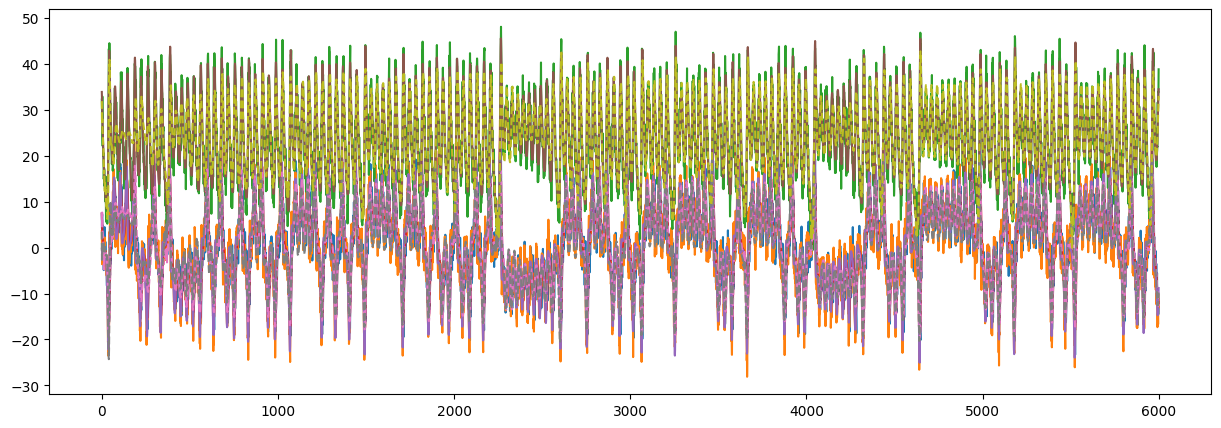

In [173]:
plt.figure(figsize=(15,5))
plt.plot(DATA["train"]["u"])
plt.plot(DATA_clean["train"]["u"])
plt.plot(u_est_arr[:,0,:].T,'--')
# plt.plot(u_est_arr[:,1,:].T,'--')
# plt.plot(u_est_arr[:,2,:].T,'--')
# plt.plot(u_est_arr[:,3,:].T,'--')

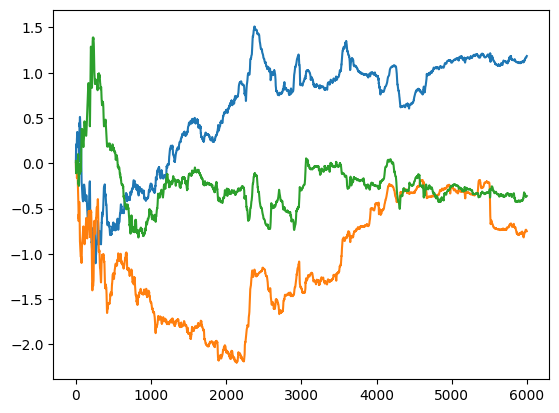

In [174]:
plt.plot(np.mean(Wo_est_arr[0,:,:], axis=0))
plt.plot(np.mean(Wo_est_arr[1,:,:], axis=0))
plt.plot(np.mean(Wo_est_arr[2,:,:], axis=0))

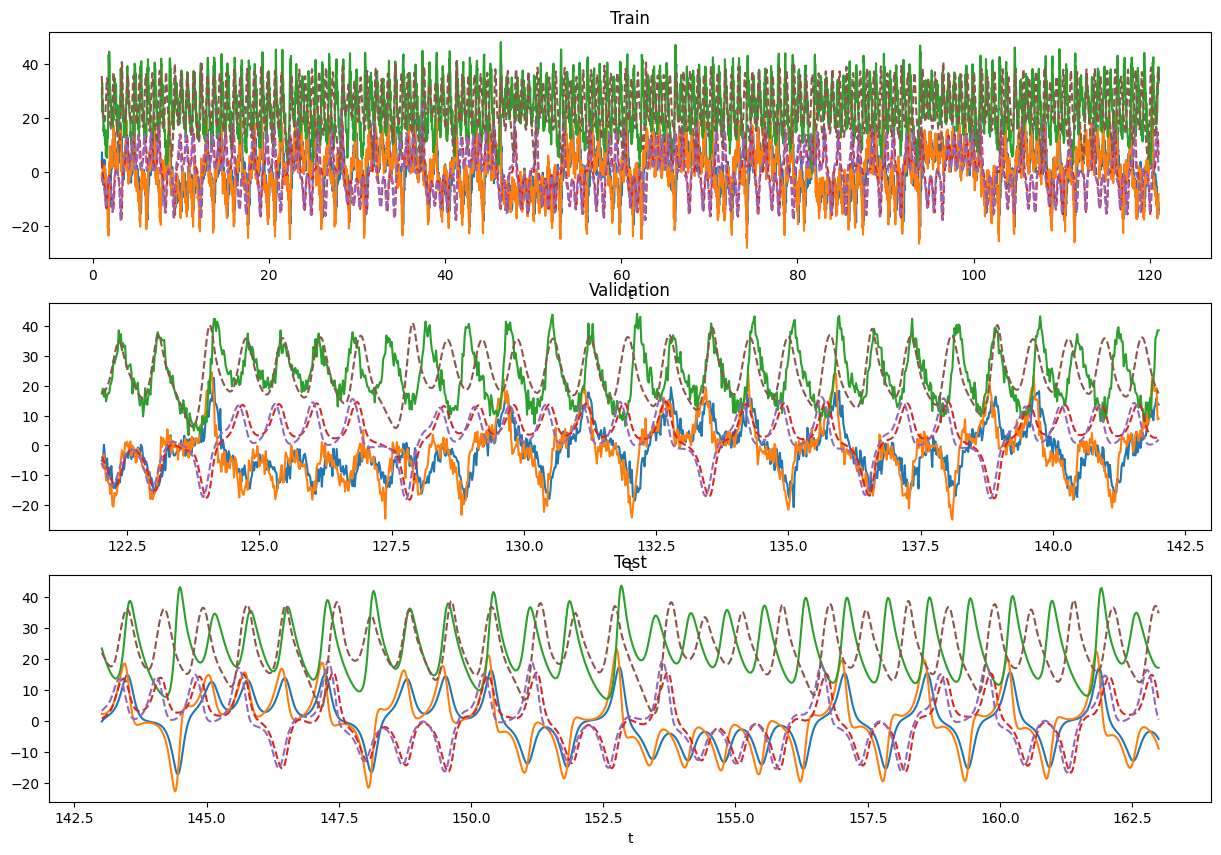

In [175]:
my_ESN.W_out = Wo_kf
_, y_pred = my_ESN.closed_loop_with_washout(U_washout=DATA["train"]["u_washout"], 
                                                    N_t=len(DATA["train"]["u"]))
y_pred = y_pred[1:]
plt.figure(figsize=(15,10))
plt.subplot(3,1,1)
plt.plot(DATA["train"]["t"],DATA["train"]["y"])
plt.plot(DATA["train"]["t"],y_pred,'--')
plt.xlabel('t')
plt.title('Train')

_, y_pred = my_ESN.closed_loop_with_washout(U_washout=DATA["val"]["u_washout"], 
                                                    N_t=len(DATA["val"]["u"]))
y_pred = y_pred[1:]
plt.subplot(3,1,2)
plt.plot(DATA["val"]["t"],DATA["val"]["y"])
plt.plot(DATA["val"]["t"],y_pred,'--')
plt.xlabel('t')
plt.title('Validation')

_, y_pred = my_ESN.closed_loop_with_washout(U_washout=DATA_clean["test"]["u_washout"], 
                                                    N_t=len(DATA_clean["test"]["u"]))
y_pred = y_pred[1:]
plt.subplot(3,1,3)
plt.plot(DATA_clean["test"]["t"],DATA_clean["test"]["y"])
plt.plot(DATA_clean["test"]["t"],y_pred,'--')
plt.xlabel('t')
plt.title('Test')

plt.show()

In [169]:
Wo_ls

array([[ -35.75915574,   74.34469723,   51.38782489],
       [   0.26419035,  -57.96808183,  174.83646096],
       [ -18.10803752,  -61.30114721, -118.49315639],
       ...,
       [ -47.94911629,  -17.3484612 ,   -4.32105519],
       [ -64.05311331,  -45.20509131,  -33.28449976],
       [  30.41750777,   46.6034783 ,   36.36063331]])

In [170]:
Wo_kf

array([[-2.24183501,  4.26948745, -2.58256731],
       [-2.61741711,  3.15041252,  1.38003451],
       [-0.05072319,  2.98769111, -3.16203357],
       ...,
       [-0.67942331, -0.33611888, -1.86702072],
       [ 0.25785976,  1.53336377,  3.102921  ],
       [-2.05314519,  0.01500416, -1.14504432]])